In [44]:
#from data import CocoDatasetManager
from collections import Counter
from backbone import ClassificationRCNN
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt

In [45]:
# Check if CUDA (GPU support) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Loading the dataset

In [46]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# Load the dataset
train_dataset = datasets.ImageFolder(root='/home/amanandhar/Transferlearning/RCNN-classification/src/data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/home/amanandhar/Transferlearning/RCNN-classification/src/data/validation', transform=transform)

'''
# Split the dataset into train and test sets
train_size = int(0.8 * len(full_dataset))  # 80% of the dataset
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
'''

# Create DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)


In [47]:
print("Number of training Images: ", len(train_dataset))
print("Number of test_loader: ", len(test_dataset))

Number of training Images:  49528
Number of test_loader:  4952


## Loading the model

In [35]:
'''
model = ClassificationRCNN(num_classes=78)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
'''

'\nmodel = ClassificationRCNN(num_classes=78)\ncriterion = torch.nn.CrossEntropyLoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001)\n'

In [48]:
model = ClassificationRCNN(num_classes=78)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)


In [49]:
model = model.to(device)  # Move the model to GPU

In [50]:
model

ClassificationRCNN(
  (resnet_backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

## Training the model

In [51]:
num_epochs = 120
loss_graph = []
loss_batch_graph=[]
accuracy_graph = []
validation_loss=[]

print(f"Starting training for {num_epochs} epochs.")

for epoch in range(num_epochs):
    model.train() 
    print(f"Epoch {epoch+1} started.")
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        try:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0: 
                loss_value = loss.item()
                loss_batch_graph.append(loss_value)
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch {i}, Loss: {loss_value:.4f}")

        except Exception as e:
            print(f"An error occurred: {e}")
    loss_graph.append(loss_value)

    # Validation phase
    model.eval()  
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(test_loader)
    accuracy = (correct_predictions / total_predictions) * 100
    accuracy_graph.append(accuracy)
    validation_loss.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] completed, Training Loss: {loss.item():.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')


Starting training for 120 epochs.
Epoch 1 started.
Epoch [1/120], Batch 0, Loss: 4.3720
Epoch [1/120], Batch 10, Loss: 4.3662
Epoch [1/120], Batch 20, Loss: 4.3619
Epoch [1/120], Batch 30, Loss: 4.3573
Epoch [1/120], Batch 40, Loss: 4.3527
Epoch [1/120], Batch 50, Loss: 4.3505
Epoch [1/120], Batch 60, Loss: 4.3440
Epoch [1/120], Batch 70, Loss: 4.3362
Epoch [1/120], Batch 80, Loss: 4.3314
Epoch [1/120], Batch 90, Loss: 4.3281
Epoch [1/120], Batch 100, Loss: 4.3200
Epoch [1/120], Batch 110, Loss: 4.3159
Epoch [1/120], Batch 120, Loss: 4.3197
Epoch [1/120], Batch 130, Loss: 4.3079
Epoch [1/120], Batch 140, Loss: 4.2888
Epoch [1/120], Batch 150, Loss: 4.2932
Epoch [1/120], Batch 160, Loss: 4.2930
Epoch [1/120], Batch 170, Loss: 4.2789
Epoch [1/120], Batch 180, Loss: 4.2745
Epoch [1/120], Batch 190, Loss: 4.2533
Epoch [1/120] completed, Training Loss: 4.3397, Validation Loss: 4.2650, Accuracy: 32.09%
Epoch 2 started.
Epoch [2/120], Batch 0, Loss: 4.2660
Epoch [2/120], Batch 10, Loss: 4.258

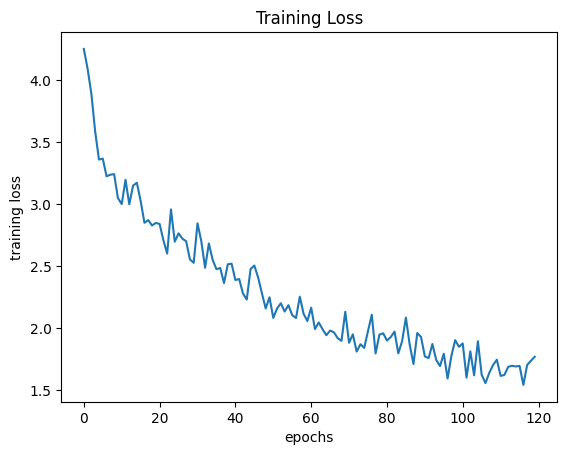

In [52]:
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.plot(loss_graph)

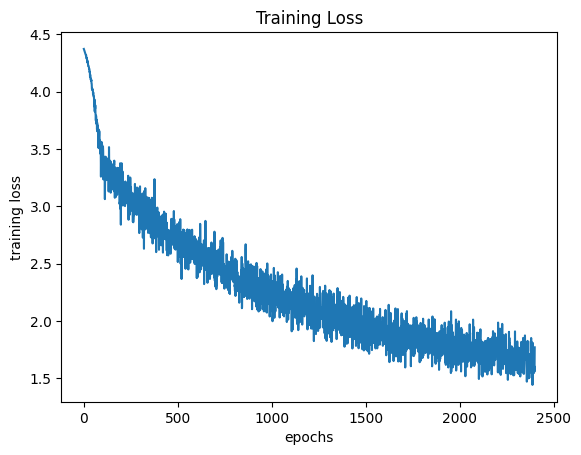

In [53]:
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.plot(loss_batch_graph)

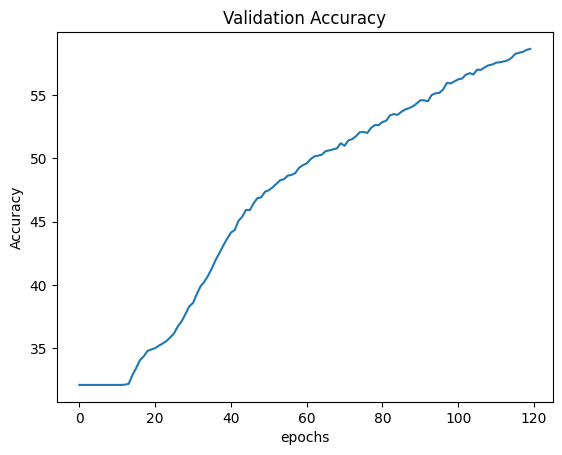

In [54]:
plt.title("Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.plot(accuracy_graph)

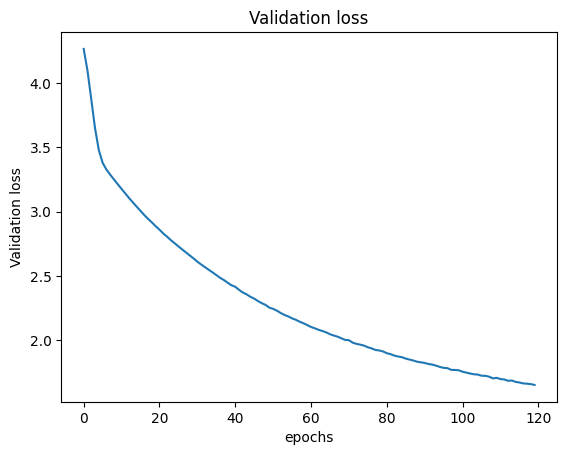

In [55]:
plt.title("Validation loss")
plt.xlabel("epochs")
plt.ylabel("Validation loss")
plt.plot(validation_loss)

Text(0, 0.5, 'loss')

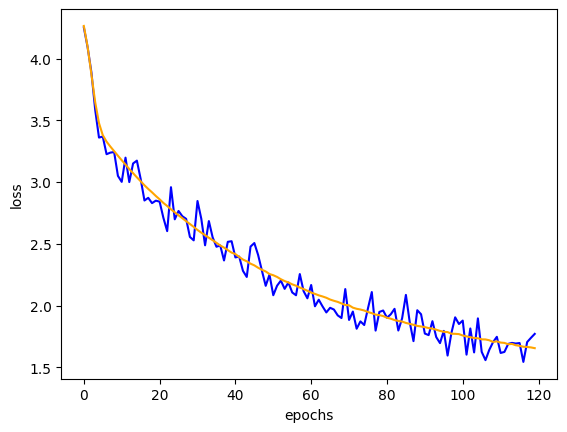

In [62]:
plt.plot(loss_graph,color='blue',label='training loss')
plt.plot(validation_loss,color='orange',label='validation_loss')
plt.xlabel("epochs")
plt.ylabel("loss")